# Variance-based sensitivity analysis

S. Eggl

[Variance-based sensitivity analysis](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) decomposes the variance of a model output into fractions that can be attributed to model inputs.
Here we use [SALib](https://salib.readthedocs.io/en/latest/) a sensitivity analysis package to explore which parameters matter most for the impact. Here, we will explore the sensitivity of the momentum enhancehment factor beta to various parameters related to [DART](https://dart.jhuapl.edu/). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [3]:
def beta(msc,me,Vinf,Ve,eta,eps):
    """Momentum enhancement factor beta according to DART Beta Memo (2020).
    
    Parameters:
    -----------
    msc    ... [float, kg] mass of DART spacecraft (dry + fuel remnants)
    me     ... [float, kg] total mass of ejecta
    Vinf   ... [float, m/s] incoming relative velocity of DART wrt Dimorphos
    Ve     ... [float, m/s] norm of the sum of all ejecta velocity vectors 
    eta    ... [float, rad] angle between Vinf and surface normal (around 180 deg)
    eps    ... [floa,rad] angle between Ve and surface normal (around 0 deg)
    
    Returns:
    --------
    beta  ... momentum enhancement factor: beta = (msc Vinf.nhat - me Ve.nhat)/(msc Vinf.nhat)
    """
    cos=np.cos
    
    imp = msc*Vinf*cos(eta)
    
    bet = 1 - me*Ve*cos(eps)/imp
    
    return bet
    

In [4]:
beta(600,6000,6000,600,np.pi,0)

2.0

In [5]:
# Define the model inputs and ranges for quasi random sampling
problem = {
    'num_vars': 6,
    'names': ['msc','mejecta','Vinf','Vejecta','eta','eps'],
    'bounds': [[500, 650],
               [0, 6000],
               [6100, 6900],
               [0,600],
               [np.pi/2,3*np.pi/2],
               [-np.pi/4,np.pi/4]]
}
# Number of samples (must be power of 2)
n_samples=2**9
print('Number of samples:',n_samples)

# Generate samples
param_values = saltelli.sample(problem, n_samples)

# Run model (example)
Y = beta(param_values[:,0],param_values[:,1],param_values[:,2],param_values[:,3],param_values[:,4],param_values[:,5])

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

Number of samples: 512
Parameter S1 S1_conf ST ST_conf
msc 0.000045 0.001073 0.000299 0.003788
mejecta 0.002468 0.018287 0.093510 0.490107
Vinf -0.000314 0.000830 0.002545 0.003732
Vejecta 0.008981 0.011062 0.103017 0.144863
eta 0.058816 0.269234 0.505147 0.709446
eps 0.000191 0.001936 0.000956 0.002076

Parameter_1 Parameter_2 S2 S2_conf
msc mejecta -0.000379 0.001319
msc Vinf -0.000410 0.000959
msc Vejecta 0.000214 0.000807
msc eta 0.003108 0.006360
msc eps -0.000403 0.000938
mejecta Vinf 0.005336 0.048061
mejecta Vejecta 0.007227 0.103507
mejecta eta -0.009425 0.111377
mejecta eps 0.004872 0.043698
Vinf Vejecta 0.000376 0.001458
Vinf eta 0.000399 0.007703
Vinf eps 0.000347 0.001218
Vejecta eta -0.019319 0.206888
Vejecta eps -0.003137 0.011557
eta eps 0.272830 0.532833


### Print and plot the first-order sensitivity indices

In [6]:
print(Si['S1'])

[ 4.54586507e-05  2.46837446e-03 -3.14494353e-04  8.98136779e-03
  5.88160862e-02  1.91145338e-04]


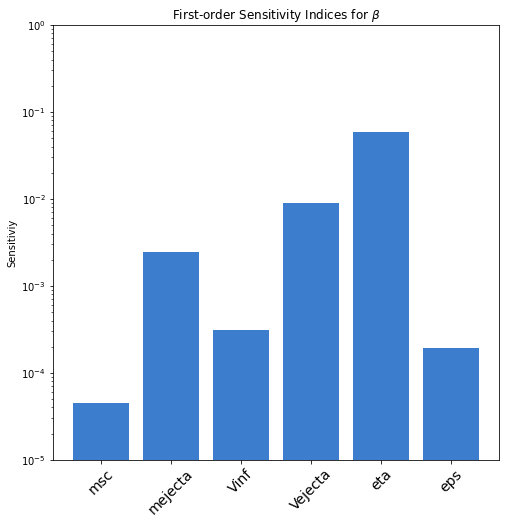

In [7]:
plt.figure(figsize=(8, 8))
dartblue='#3c7dcd'

x = problem['names']
sobol_indices = Si['S1']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, abs(sobol_indices), color=dartblue)

plt.xticks(range(len(problem['names'])), problem['names'], fontsize=14, rotation=45)
plt.ylabel("Sensitiviy")
plt.yscale('log', nonpositive='clip')
plt.ylim(1e-5,1)

plt.title(r'First-order Sensitivity Indices for $\beta$')
plt.show()

We see that the angle between surface normal and DART impact vector (eta) has the largest influence on beta, followed by the net ejecta momentum (mejecta*Vejecta).

### We can look at the second-order indices to see higher-order interactions:

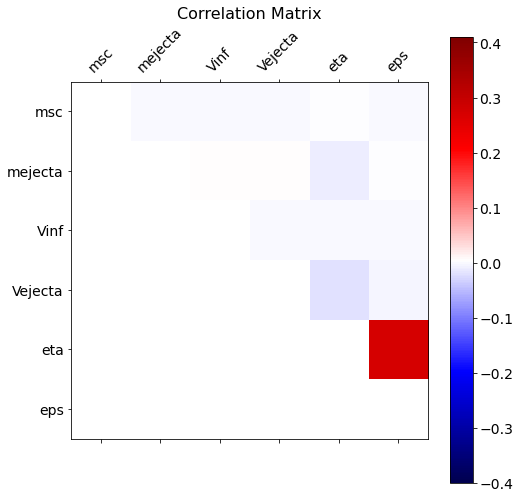

In [8]:
f = plt.figure(figsize=(8, 8))
plt.matshow(Si['S2'], fignum=f.number,cmap=plt.get_cmap('seismic'),vmin=-0.4, vmax=.41)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(range(len(problem['names'])), problem['names'], fontsize=14, rotation=45)
plt.yticks(range(len(problem['names'])),problem['names'], fontsize=14)
plt.title('Correlation Matrix', fontsize=16);

The correlation between the angles eta and eps wrt beta is clearly visible, although we did not explicitly use the surface normal vector nhat to calculate beta. The dominant quantities are again related to the magnitude of the ejecta momentum, and the angle between the impact vector of DART and the surface normal. 

### Now we can try this with (Eq. 3) in the DART memo.

In [9]:
def beta2(M,msc,dVm,dVphi,dVtheta,eTphi,eTtheta,Vinfm,Vinfphi,Vinftheta,epsm,epsphi,epstheta,nhatphi,nhattheta):
    
    """Momentum enhancement according (Eq. 3) in the DART Beta Memo (2020). See also (Eq. 1) Rivkin et al. (2021)
    
    M      ... [float, kg] mass of Dimorphos
    msc    ... [float, kg] mass of DART spacecraft (dry + fuel remnants)
    dV     ... [4 x float, m/s] lenght and direction of delta V of Dimorphos
    eT     ... [3 x float] unit vector along track Dimorphos' velocity vector
    Vinf   ... [4 x float, m/s] incoming relative velocity of DART wrt to Dimorphos
    eps    ... [4 x float] vector of ejecta momentum orthogonal to surface normal (small)
    nhat   ... [3 x float] surface normal unit vector of impact surface element
    
    Vinfn  ... [float, m/s] projection of relative velocity vector between Dimorphos and DART onto surface normal nhat
    Vinfon ... [3 x float, m/s] othogonal component of relative velocity vector between Dimophos and DART, Vinfon = Vinf - Vinfn*nhat
     """
    
    dot = vectordot
    array = np.array
    
    dV = spherical2xyz(dVm,dVphi,dVtheta)
    eT = spherical2xyz(1,eTphi,eTtheta)
    nhat = spherical2xyz(1,nhatphi,nhattheta)
    eps = spherical2xyz(epsm,epsphi,epstheta)
    Vinf = spherical2xyz(Vinfm,Vinfphi,Vinftheta)
    
    # print (dot(eps,nhat))
    Vinfn = dot(Vinf,nhat)
    print(Vinf[0:4,:])
    Vinfon = Vinf - vectorresize(Vinfn,nhat)
    
    beta = M/msc*dot(dV,eT) - dot(Vinfon,eT)+Vinfn*dot(eps,eT)/(Vinfn*dot(nhat,eT)+Vinfn*dot(eps,eT))
    
    return beta 
    

In [10]:
def vectordot(a,b):
    c = [np.dot(a[i,:],b[i,:]) for i in range(len(a[:,0]))]
    return np.array(c)
    

In [11]:
def vectorresize(a,b):
    c = [a[i]*b[i,:] for i in range(len(a[:]))]
    return np.array(c)

In [12]:
def spherical2xyz(r,phi,theta):
    cos=np.cos
    sin=np.sin
    array=np.array
    
    x=r*cos(phi)*sin(theta)
    y=r*sin(phi)*sin(theta)
    z=r*cos(theta)
    
    return array([x,y,z]).T

In [13]:
# Define the model inputs and ranges for quasi random sampling
problem = {
    'num_vars': 15,
    'names': ['M','msc','dVmag','dVphi','dVtheta',
              'eTphi','eTtheta',
              'Vinfmag','Vinfphi','Vinftheta',
              'epsmag','epsphi','epstheta','nhatphi','nhattheta'],
    'bounds': [[4*np.pi*164**3/3*1150, 4*np.pi*164**3/3*3580], # M
               [580, 620], # msc
               [0.001, 0.008], # dVm [m/s]
               [np.pi-np.pi/4, np.pi+np.pi/4], # dVphi [rad]
               [0, np.pi], # dVtheta [rad]
               [np.pi-np.pi/4, np.pi+np.pi/4], # eTphi [rad]
               [0, np.pi], # eTtheta [rad]
               [6100, 6900], #Vinfm [m/s]
               [np.pi-np.pi/4, np.pi+np.pi/4], # Vinfphi [rad]
               [0, np.pi], # dVinftheta [rad]
               [0.0, 0.3], # epsm []  
               [-np.pi/4,np.pi/4], # epsphi [rad]
               [0,np.pi], # epstheta [rad]
               [-np.pi/4,np.pi/4], #nhatphi [rad],
               [0,np.pi] # nhattheta [rad]  
              ] 
                
}
# Number of samples (must be power of 2)
n_samples=2**9
print('Number of samples:',n_samples)


# Generate samples
param_values = saltelli.sample(problem, n_samples)

# Run model (example)
Y = beta2(param_values[:,0],param_values[:,1],param_values[:,2],param_values[:,3],param_values[:,4],param_values[:,5],
         param_values[:,6],param_values[:,7],param_values[:,8],param_values[:,9],param_values[:,10],param_values[:,11],
         param_values[:,12],param_values[:,13],param_values[:,14])

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)

Number of samples: 512
[[-5373.07886123 -1715.79751287 -3368.96659072]
 [-5373.07886123 -1715.79751287 -3368.96659072]
 [-5373.07886123 -1715.79751287 -3368.96659072]
 [-5373.07886123 -1715.79751287 -3368.96659072]]
Parameter S1 S1_conf ST ST_conf
M 0.010980 0.036462 0.102576 0.021849
msc -0.000327 0.002727 0.000499 0.000127
dVmag -0.000584 0.062339 0.212648 0.039675
dVphi 0.015377 0.026351 0.027643 0.010924
dVtheta 0.127337 0.098350 0.811934 0.159162
eTphi 0.006964 0.029219 0.035222 0.013272
eTtheta 0.205775 0.121957 0.868568 0.167554
Vinfmag 0.000011 0.000051 0.000000 0.000000
Vinfphi 0.000163 0.000382 0.000009 0.000002
Vinftheta 0.000699 0.001523 0.000135 0.000027
epsmag -0.000000 0.000001 0.000000 0.000000
epsphi -0.000001 0.000001 0.000000 0.000000
epstheta -0.000000 0.000001 0.000000 0.000000
nhatphi 0.000052 0.000288 0.000007 0.000002
nhattheta 0.002994 0.001005 0.000074 0.000012

Parameter_1 Parameter_2 S2 S2_conf
M msc 0.016184 0.068515
M dVmag 0.006153 0.070777
M dVphi 0.0233

Plot first order Sensitivity Indices.

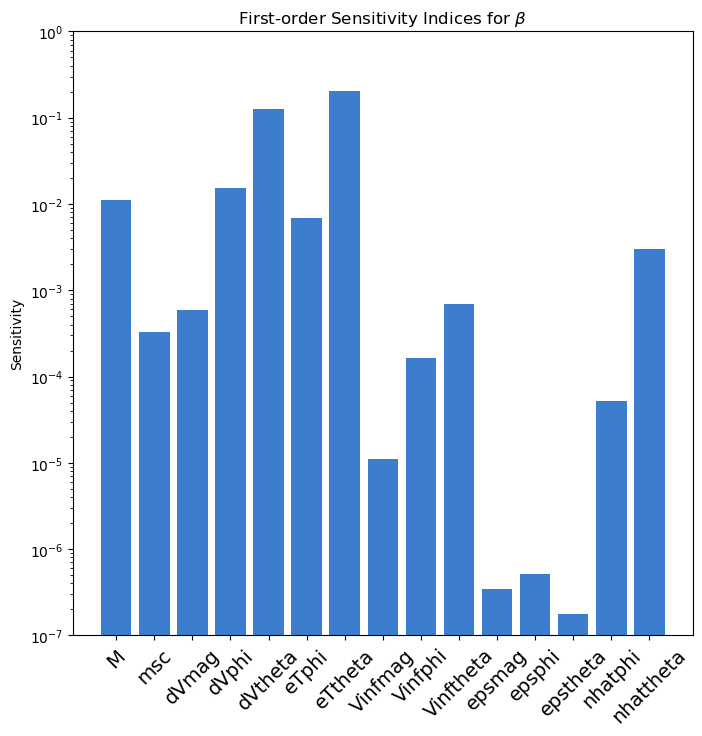

In [14]:
plt.figure(dpi=100,figsize=(8, 8))
dartblue='#3c7dcd'

x = problem['names']
sobol_indices = Si['S1']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, abs(sobol_indices), color=dartblue)

plt.xticks(range(len(problem['names'])), problem['names'], fontsize=14, rotation=45)
plt.ylabel("Sensitivity")
plt.yscale('log', nonpositive='clip')
plt.ylim(1e-7,1)

plt.title(r'First-order Sensitivity Indices for $\beta$')
plt.show()

Plot second order interactions.

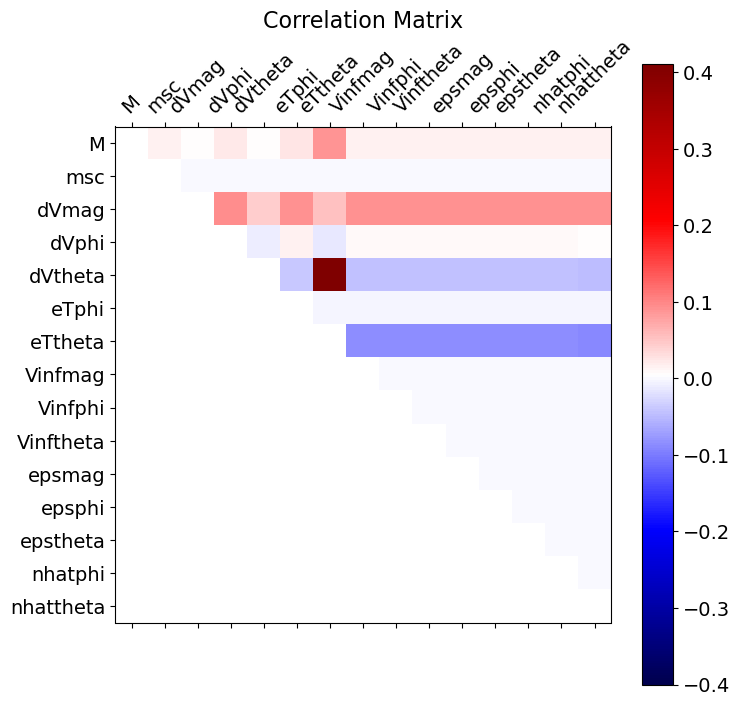

In [15]:
f = plt.figure(dpi=100,figsize=(8, 8))
plt.matshow(Si['S2'], fignum=f.number,cmap=plt.get_cmap('seismic'),vmin=-0.4, vmax=.41)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(range(len(problem['names'])), problem['names'], fontsize=14, rotation=45)
plt.yticks(range(len(problem['names'])),problem['names'], fontsize=14)
plt.title('Correlation Matrix', fontsize=16);